# **DSIM - E03 Assignment: Image Compression via Color Space Blurring**

We exploit the properties of the **YCbCr** color space to demonstrate that the human visual system is far more sensitive to changes in **luminance** (Y) than in **chrominance** (Cb, Cr).

**Approach:**
1. Load a custom image and convert it to YCbCr
2. Blur only the chroma channels (Cb, Cr) → minimal perceived quality loss
3. Blur only the luma channel (Y) → severe perceived quality loss
4. Compare results across multiple blur intensities (Gaussian $\sigma$)

In [ ]:
import numpy as np
from matplotlib import pyplot as plt

from skimage import io, color, filters, img_as_float

plt.rcParams['figure.figsize'] = [15, 5]

## 1. Load and inspect the image

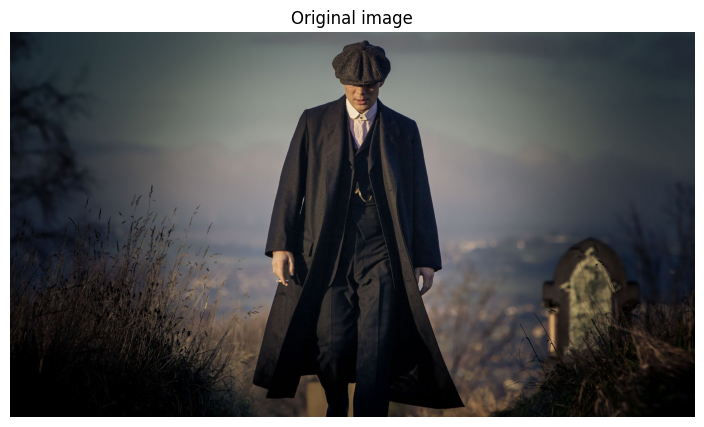

Shape: (1080, 1920, 3)
Dtype: uint8


In [ ]:
im = io.imread('shelby.jpg')
plt.imshow(im)
plt.title('Original image')
plt.axis('off')
plt.show()

print('Shape:', im.shape)
print('Dtype:', im.dtype)

Dtype after conversion: float64


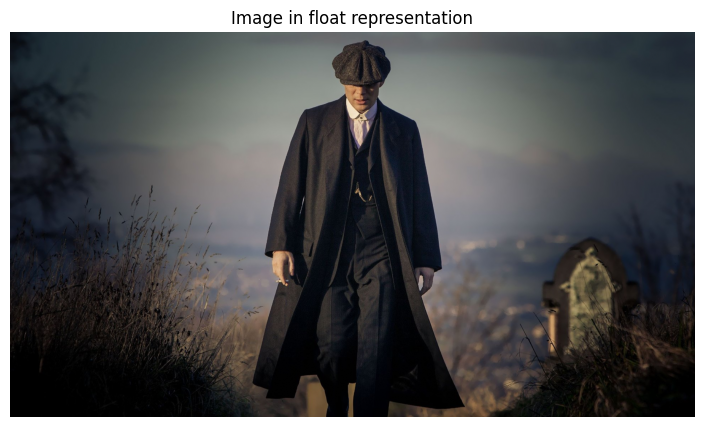

In [ ]:
im_float = img_as_float(im[:, :, :3]) # discard alpha channel if present
print('Dtype after conversion:', im_float.dtype)

plt.imshow(im_float)
plt.title('Image in float representation')
plt.axis('off')
plt.show()

## 2. Convert to YCbCr color space

The YCbCr color space separates an image into:
- **Y** (Luma): brightness information, roughly a weighted sum of RGB:
$$Y = 0.299 \cdot R + 0.587 \cdot G + 0.114 \cdot B$$
- **Cb** (Chroma blue-yellow): how much the color deviates from gray toward blue/yellow
- **Cr** (Chroma red-green): how much the color deviates from gray toward red/green

This separation is used in JPEG compression: since humans are less sensitive to chroma detail, Cb and Cr can be heavily compressed with minimal perceptual impact.

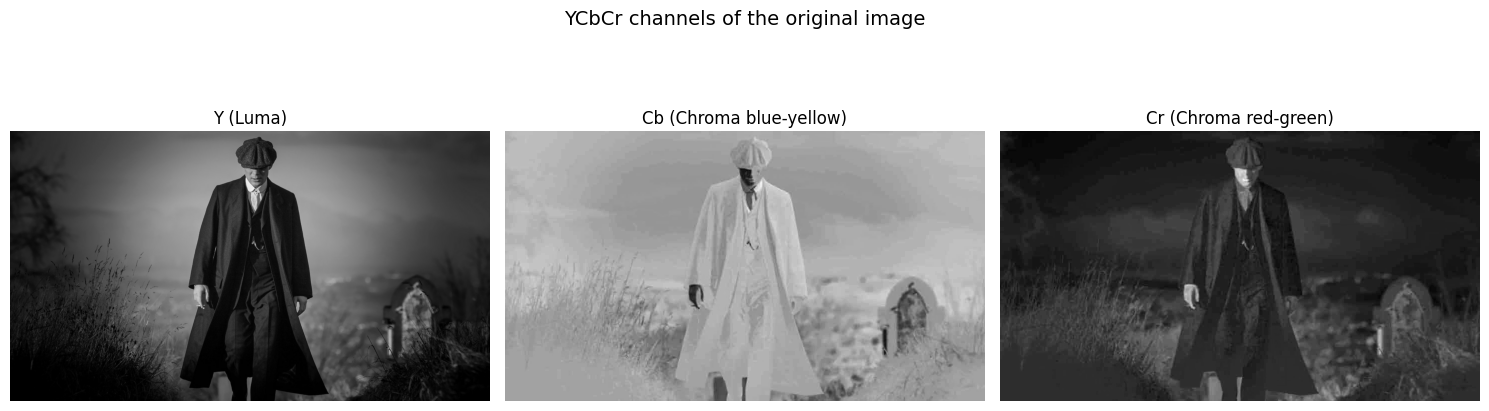

In [ ]:
im_ycbcr = color.rgb2ycbcr(im_float)

plt.subplot(1, 3, 1)
plt.imshow(im_ycbcr[:, :, 0], cmap='gray')
plt.title('Y (Luma)')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(im_ycbcr[:, :, 1], cmap='gray')
plt.title('Cb (Chroma blue-yellow)')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(im_ycbcr[:, :, 2], cmap='gray')
plt.title('Cr (Chroma red-green)')
plt.axis('off')

plt.suptitle('YCbCr channels of the original image', fontsize=14)
plt.tight_layout()
plt.show()

## 3. Gaussian Blur

We use a Gaussian filter to reduce the information content of selected channels. The Gaussian kernel is:

$$G(x, y) = \frac{1}{2\pi\sigma^2} \cdot e^{-\frac{x^2 + y^2}{2\sigma^2}}$$

where $\sigma$ controls the blur intensity. We use `skimage.filters.gaussian` with `preserve_range=True` to avoid rescaling the YCbCr values (which are not in [0, 1]).

## 3.1 Blurring only the Chroma channels (Cb and Cr)

We blur Cb and Cr while keeping Y intact, then convert back to RGB.

In [ ]:
def compress_CbCr(im_ycbcr, sigma):
    """
    Blur only the chroma channels (Cb, Cr) of the YCbCr image,
    keep Y intact, and convert back to RGB.
    """
    im_blur = im_ycbcr.copy()

    im_blur[:, :, 1] = filters.gaussian(im_blur[:, :, 1], sigma=sigma, preserve_range=True)
    im_blur[:, :, 2] = filters.gaussian(im_blur[:, :, 2], sigma=sigma, preserve_range=True)

    im_rgb = color.ycbcr2rgb(im_blur)
    im_rgb = np.clip(im_rgb, 0, 1)

    return im_rgb, im_blur

In [ ]:
im_rgb_original = np.clip(color.ycbcr2rgb(im_ycbcr), 0, 1)

sigmas = [0, 3, 10, 30, 60]

fig, axes = plt.subplots(len(sigmas), 4, figsize=(20, 5 * len(sigmas)))

for row, sigma in enumerate(sigmas):
    im_cblur, ycbcr_blur = compress_CbCr(im_ycbcr, sigma)

    axes[row, 0].imshow(ycbcr_blur[:, :, 0], cmap='gray')
    axes[row, 0].set_title('Y (unchanged)')

    axes[row, 1].imshow(ycbcr_blur[:, :, 1], cmap='gray')
    axes[row, 1].set_title(f'Cb (σ={sigma})')

    axes[row, 2].imshow(ycbcr_blur[:, :, 2], cmap='gray')
    axes[row, 2].set_title(f'Cr (σ={sigma})')

    axes[row, 3].imshow(im_cblur)
    axes[row, 3].set_title(f'Reconstructed RGB (σ={sigma})')

    for ax in axes[row]:
        ax.axis('off')

plt.suptitle('Chroma compression (Cb + Cr blurred, Y intact)', fontsize=16, y=1.01)
plt.tight_layout()
plt.show()

Output hidden; open in https://colab.research.google.com to view.

**Observations on chroma blurring:**
- $\sigma = 0$: no blurring, image is identical to the original
- $\sigma = 3$: almost imperceptible difference; fine color detail is very slightly softened
- $\sigma = 10$: still hard to notice degradation; some color bleeding at sharp edges
- $\sigma = 30$: colors start bleeding across object boundaries, but overall image remains clear and recognizable
- $\sigma = 60$: heavy color blurring is now visible, yet the structural detail and sharpness are fully preserved — the image is still quite acceptable

This confirms that our visual system tolerates significant loss of chrominance detail. The biological reason is that the human retina has far fewer color-sensitive cones than brightness-sensitive rods, and the spatial resolution of the chrominance pathways in the visual cortex is roughly **1/4 that of the luminance pathway**. We literally cannot see fine color detail, even when it is present.

## 3.2 Blurring only the Luma channel (Y)

We blur Y while keeping Cb and Cr intact, then convert back to RGB.

In [ ]:
def compress_Y(im_ycbcr, sigma):
    """
    Blur only the luma channel (Y) of the YCbCr image,
    keep Cb and Cr intact, and convert back to RGB.
    """
    im_blur = im_ycbcr.copy()

    im_blur[:, :, 0] = filters.gaussian(im_blur[:, :, 0], sigma=sigma, preserve_range=True)

    im_rgb = color.ycbcr2rgb(im_blur)
    im_rgb = np.clip(im_rgb, 0, 1)

    return im_rgb, im_blur

In [ ]:
fig, axes = plt.subplots(len(sigmas), 4, figsize=(20, 5 * len(sigmas)))

for row, sigma in enumerate(sigmas):
    im_yblur, ycbcr_blur = compress_Y(im_ycbcr, sigma)

    axes[row, 0].imshow(ycbcr_blur[:, :, 0], cmap='gray')
    axes[row, 0].set_title(f'Y (σ={sigma})')

    axes[row, 1].imshow(ycbcr_blur[:, :, 1], cmap='gray')
    axes[row, 1].set_title('Cb (unchanged)')

    axes[row, 2].imshow(ycbcr_blur[:, :, 2], cmap='gray')
    axes[row, 2].set_title('Cr (unchanged)')

    axes[row, 3].imshow(im_yblur)
    axes[row, 3].set_title(f'Reconstructed RGB (σ={sigma})')

    for ax in axes[row]:
        ax.axis('off')

plt.suptitle('Luma compression (Y blurred, Cb + Cr intact)', fontsize=16, y=1.01)
plt.tight_layout()
plt.show()

Output hidden; open in https://colab.research.google.com to view.

**Observations on luma blurring:**
- $\sigma = 0$: no blurring, identical to original
- $\sigma = 3$: blurring is already slightly visible — a clear contrast with chroma blurring where $\sigma=3$ was imperceptible
- $\sigma = 10$: the image is clearly blurred, edges and textures are visibly degraded
- $\sigma = 30$: most fine details are lost; only coarse shapes remain
- $\sigma = 60$: the image is essentially unrecognizable in terms of detail, only large color blobs remain

Despite affecting only **1 channel** (vs 2 for chroma), the perceptual impact is dramatically worse. This asymmetry is striking: at $\sigma = 10$, blurring 2 chroma channels produces a nearly invisible effect, while blurring just 1 luma channel clearly degrades the image. The Y channel encodes the structural information — edges, textures, contrast gradients — that our visual system uses for object recognition, depth perception, and scene understanding.

## 4. Side-by-side comparison

In [ ]:
fig, axes = plt.subplots(len(sigmas), 3, figsize=(18, 5 * len(sigmas)))

for row, sigma in enumerate(sigmas):
    im_cblur, _ = compress_CbCr(im_ycbcr, sigma)
    im_yblur, _ = compress_Y(im_ycbcr, sigma)

    axes[row, 0].imshow(im_rgb_original)
    axes[row, 0].set_title('Original')

    axes[row, 1].imshow(im_cblur)
    axes[row, 1].set_title(f'Chroma blur (σ={sigma})')

    axes[row, 2].imshow(im_yblur)
    axes[row, 2].set_title(f'Luma blur (σ={sigma})')

    for ax in axes[row]:
        ax.axis('off')

plt.suptitle('Side-by-side: Chroma vs Luma compression', fontsize=16, y=1.01)
plt.tight_layout()
plt.show()

Output hidden; open in https://colab.research.google.com to view.

**Observation:** the side-by-side comparison makes the asymmetry visually obvious. At every $\sigma$ value, the chroma-blurred image (center column) is perceptually much closer to the original (left) than the luma-blurred image (right). The most informative comparison is at $\sigma = 30$: the chroma-blurred version is still a perfectly usable image with slight color bleeding, while the luma-blurred version has lost all fine detail and is barely recognizable.

This experiment provides an intuitive justification for **chroma subsampling** in image and video compression.

## Summary

| Compression | Channels blurred | Effect at low $\sigma$ | Effect at high $\sigma$ |
|---|---|---|---|
| **Chroma (Cb+Cr)** | 2 out of 3 | Almost imperceptible | Color bleeding, but still acceptable |
| **Luma (Y)** | 1 out of 3 | Already noticeable | Severely degraded, unusable |

**Conclusion:** the Y channel carries the structural information (edges, textures, contrast) that our visual system relies on most heavily. The Cb and Cr channels encode color differences that we perceive with much lower spatial resolution.

This asymmetry is the foundation of compression standards like **JPEG**, which uses **chroma subsampling** to reduce data:

| Subsampling | Chroma resolution | Bandwidth saving |
|:---:|---|:---:|
| 4:4:4 | Full (no subsampling) | 0% |
| 4:2:2 | Half horizontal resolution | 33% |
| 4:2:0 | Half horizontal + half vertical | **50%** |

The 4:2:0 scheme (used by default in JPEG and in most video codecs like H.264/H.265) discards 75% of the chroma samples while preserving all luma samples, achieving a 50% reduction in raw data with negligible perceptual loss — exactly the behavior demonstrated by our experiment.

**Technical notes:**
- `img_as_float()` converts uint8 [0, 255] to float64 [0.0, 1.0], which is required by `skimage.color.rgb2ycbcr`
- `preserve_range=True` in `filters.gaussian` is critical: without it, skimage would rescale YCbCr values to [0, 1], corrupting the color space (Y ranges ~[16, 235], Cb/Cr range ~[16, 240])
- `np.clip(im_rgb, 0, 1)` after conversion back to RGB prevents out-of-range values caused by floating-point rounding